# LoC thresholding notebook

This notebook loads a set of Z-tracks taken across an image volume from the lung-on-a-chip project and thresholds positive/negative expression of set markers based on a manual and unbiased assessment of the underlying images:

1. Load z-tracks, segmentation and images.
2. Initiate a Napari viewer with key bindings to annotate positive/negative expressing cells
3. Assess results
4. Quantify based on manually chosen thresholds

In [3]:
import btrack # import tracking software
import napari # image viewer
from skimage import io # image loader and viewer
import os # for filename manipulations
import glob # for more fn operations 
import pandas as pd # module for data org 
import matplotlib.pyplot as plt # module for plotting
import seaborn as sns # module for plotting
import numpy as np # for math operations
import re
from homuncu_loc import dataio
sns.set(font='Nimbus Sans', style = 'white') # my favourite formatting :)
sns.set_palette('PiYG') # my favourite colours :D 

## 1. Load images and labels

In [115]:
search_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/' # search for image or input basename and dir 
image_base_name = '20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1443.tif' 
img_base_dir = dataio.find_image_directory(search_dir, image_base_name) # img_base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/images'
image_fn = os.path.join(img_base_dir, image_base_name)
image_id = dataio.ID_extractor(image_fn)
os.path.exists(image_fn)

True

In [65]:
image = io.imread(image_fn) # load image

In [116]:
# base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses'
sc_base_dir = img_base_dir.replace('images', 'sc_analyses') 
sc_fns = glob.glob(os.path.join(sc_base_dir, f'*_{image_id}*.h5'))
print(sc_fns)

['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1443_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1443_iat2.h5']


In [117]:
sc_fn = [fn for fn in sc_fns if fn.endswith('iat2.h5')][0]#sc_fns[-1]
# load labels (tracks and segmentation)
with btrack.io.HDF5FileHandler(sc_fn, 
                                   'r', 
                                       obj_type='obj_type_2'#'obj_type_2'
                                   ) as reader:
        # tracks = [t for t in reader.tracks if np.mean(t.properties['area']) > 1000]
        tracks = reader.tracks#[t for t in reader.tracks if len(t) >= 3]
        segmentation = reader.segmentation
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim = 2)
recolored_segmentation = btrack.utils.update_segmentation(segmentation, tracks)

[INFO][2023/10/27 05:10:34 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1443_iat2.h5...
[INFO][2023/10/27 05:10:34 pm] Loading tracks/obj_type_2
[INFO][2023/10/27 05:10:34 pm] Loading LBEP/obj_type_2
[INFO][2023/10/27 05:10:34 pm] Loading objects/obj_type_2 (36733, 5) (36733 filtered: None)
[INFO][2023/10/27 05:10:37 pm] Loading segmentation (51, 2304, 2304)
[INFO][2023/10/27 05:10:37 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1443_iat2.h5


In [68]:
v = napari.Viewer(title = image_id)
v.add_image(image, channel_axis = -1)
v.add_tracks(napari_tracks)
v.add_labels(recolored_segmentation)

<Labels layer 'recolored_segmentation' at 0x7effae22a040>

In [118]:
output_dir = os.path.dirname(sc_fn)
output_dir

'/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses'

## 2. Initiate a napari session with key bindings

## Thresholding instructions

In [16]:
viewer = napari.Viewer(title = f'thresholding {image_id}')

viewer.add_image(image, channel_axis=-1)
track_layer = viewer.add_tracks(napari_tracks, tail_length=0, visible = False)
labels = viewer.add_labels(recolored_segmentation)
labels.contour = 1 # this makes all the masks into outlines but might slow your computer down A LOT (comment out line if so) 
global image_id 
# image_id = re.search(r'\d+(?=_z_tracks)', os.path.basename(sc_fn)).group()
output_dir =os.path.dirname(sc_fn)
@viewer.bind_key('t')
def ch1_extract_positive_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
         ### get index of cell instance of selected frame
        cell_index = positive_track.t.index(time)
        ### extract the pixel intensity of that segment
        px_int =  positive_track['mean_intensity'][:,1][cell_index]
        ### write to output file
        with open(os.path.join(output_dir, f"{image_id}_ch1_positive_details.csv"),"a") as f:
            f.write(f"{cell_ID, time, px_int}\n")
        print(f'ID {cell_ID} recorded')
    except Exception:
        print('Looks like there was no identifiable track there')
   
@viewer.bind_key('b')
def ch1_extract_negative_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
        ### get index of cell instance of selected frame
        cell_index = positive_track.t.index(time)
        ### extract the pixel intensity of that segment
        px_int =  positive_track['mean_intensity'][:,1][cell_index]
        with open(os.path.join(output_dir, f"{image_id}_ch1_negative_details.csv"),"a") as f:
            f.write(f"{cell_ID, time, px_int}\n")
        print(f'ID {cell_ID} recorded')
    except Exception:
        print('Looks like there was no identifiable track there')
    
@viewer.bind_key('y')
def ch2_extract_positive_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
        ### get index of cell instance of selected frame
        cell_index = positive_track.t.index(time)
        ### extract the pixel intensity of that segment
        px_int =  positive_track['mean_intensity'][:,2][cell_index]
        ### write to output file
        with open(os.path.join(output_dir, f"{image_id}_ch2_positive_details.csv"),"a") as f:
            f.write(f"{cell_ID, time, px_int}\n")
        print(f'ID {cell_ID} recorded')
    except Exception:
        print('Looks like there was no identifiable track there')
    
@viewer.bind_key('n')
def ch2_extract_negative_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
        ### get index of cell instance of selected frame
        cell_index = positive_track.t.index(time)
        ### extract the pixel intensity of that segment
        px_int =  positive_track['mean_intensity'][:,2][cell_index]
        ### write to output file
        with open(os.path.join(output_dir, f"{image_id}_ch2_negative_details.csv"),"a") as f:
            f.write(f"{cell_ID, time, px_int}\n")
        print(f'ID {cell_ID} recorded')
    except Exception:
        print('Looks like there was no identifiable track there')
    
@viewer.bind_key('u')
def ch3_extract_positive_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
        ### get index of cell instance of selected frame
        cell_index = positive_track.t.index(time)
        ### extract the pixel intensity of that segment
        px_int =  positive_track['mean_intensity'][:,3][cell_index]
        ### write to output file
        with open(os.path.join(output_dir, f"{image_id}_ch3_positive_details.csv"),"a") as f:
            f.write(f"{cell_ID, time, px_int}\n")
        print(f'ID {cell_ID} recorded')
    except Exception:
        print('Looks like there was no identifiable track there')
    
@viewer.bind_key('m')
def ch3_extract_negative_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
        ### get index of cell instance of selected frame
        cell_index = positive_track.t.index(time)
        ### extract the pixel intensity of that segment
        px_int =  positive_track['mean_intensity'][:,3][cell_index]
        ### write to output file
        with open(os.path.join(output_dir, f"{image_id}_ch3_negative_details.csv"),"a") as f:
            f.write(f"{cell_ID, time, px_int}\n")
        print(f'ID {cell_ID} recorded')
    except Exception:
        print('Looks like there was no identifiable track there')
    

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:309: RuntimeWarning: divide by zero encountered in divide
  alpha = (self.head_length + self.current_time - times) / (


ID 151 recorded
ID 22 recorded
ID 130 recorded
ID 18 recorded
ID 108 recorded
ID 103 recorded
ID 4252 recorded
ID 812 recorded
ID 4154 recorded
ID 4301 recorded
ID 4139 recorded
ID 4026 recorded
ID 4855 recorded
ID 4874 recorded
ID 4065 recorded
ID 4861 recorded
ID 4901 recorded
ID 3999 recorded
ID 4050 recorded
ID 4148 recorded
ID 4787 recorded
ID 4512 recorded
ID 4506 recorded
ID 4745 recorded
ID 4697 recorded
ID 4708 recorded
ID 4763 recorded
ID 4644 recorded
ID 4635 recorded
ID 4780 recorded
ID 3102 recorded
ID 3090 recorded
ID 3038 recorded
ID 3178 recorded
ID 3045 recorded
ID 3033 recorded
ID 4556 recorded
ID 4782 recorded
ID 4746 recorded
ID 4735 recorded
ID 4659 recorded
ID 4701 recorded
ID 4682 recorded
ID 3127 recorded
ID 3178 recorded
ID 804 recorded
ID 866 recorded
ID 4173 recorded
ID 4466 recorded
ID 4344 recorded
ID 4312 recorded
ID 122 recorded
ID 425 recorded
ID 1288 recorded
ID 1470 recorded
ID 1849 recorded
ID 1642 recorded
ID 1311 recorded
ID 1456 recorded
ID 929 rec

## Load results of unbiased thresholding

Loading many single-cell measurements of positive and negative cells to decide where the threshold between them is (simply by plotting and deciding at the moment).

In [105]:
print(glob.glob(os.path.join(sc_base_dir, f'{image_id}_ch{channel}*.csv')))

['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/1442_ch2_positive_details.csv']


In [104]:
print(output_dir)

/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses


In [106]:
df = dict()
channels = [1, 2]#, 2]#, 2] #1 , 2
for channel in channels:
    for fn in glob.glob(os.path.join(sc_base_dir, f'{image_id}_ch{channel}*.csv')):
        if 'positive' in fn:
            positive_df = pd.read_csv(fn, names=["cell ID", "z slice", "Positive Mean Pixel Intensity"]).replace(r'\(|\)', '', regex=True)
            positive_df.apply(pd.to_numeric, errors='coerce')
        if 'negative' in fn:
            negative_df = pd.read_csv(fn, names=["cell ID", "z slice", "Negative Mean Pixel Intensity"]).replace(r'\(|\)', '', regex=True)
            negative_df.apply(pd.to_numeric, errors='coerce')
    df[channel] = pd.concat((negative_df, positive_df), axis = 1).drop(columns = ['cell ID', 'z slice']).apply(pd.to_numeric, errors='coerce')

In [119]:
channel = 2

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

Text(0.5, 1.0, 'Positive/negative pixel distribution across channel 1')

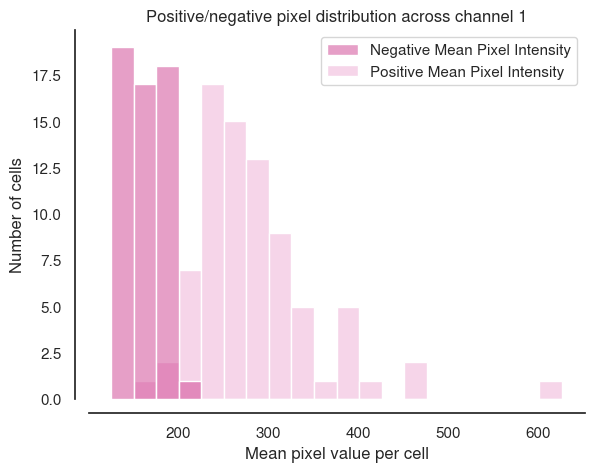

In [112]:
sns.histplot(data = df[channel], bins = 20)
sns.despine(offset = 10)
plt.xlabel('Mean pixel value per cell')
plt.ylabel('Number of cells')
plt.title(f'Positive/negative pixel distribution across channel {channel}')

## Decide threshold label and replot

In [120]:
threshold = 170

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

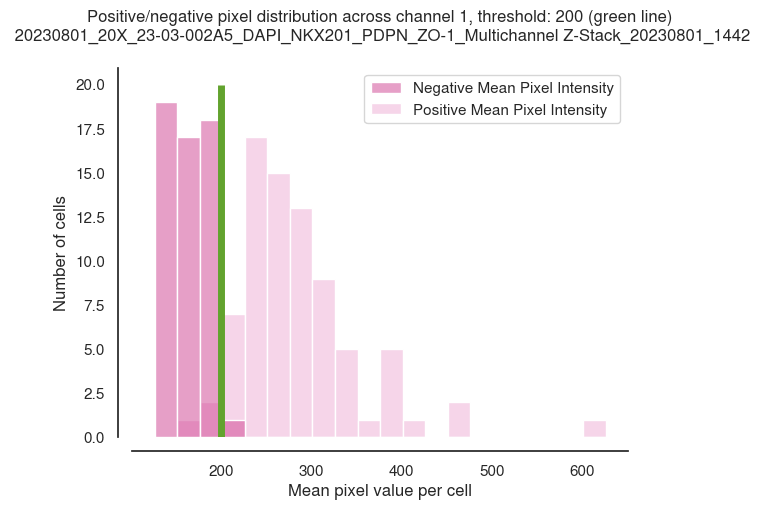

In [114]:
# channel = 1
ax = sns.histplot(data=df[channel], bins=20)
sns.despine(offset=10)
plt.vlines(x=threshold,
           ymax=ax.get_ylim()[-1],
           ymin=ax.get_ylim()[0],
           color=sns.color_palette('PiYG')[-1],  # my favorite colors :D
           linewidth=5)
# plt.text(x=threshold, y=ax.get_ylim()[-1], s='Threshold')
image_name = os.path.basename(image_fn).replace('.tif','')
plt.xlabel('Mean pixel value per cell')
plt.ylabel('Number of cells')
plt.title(f'Positive/negative pixel distribution across channel {channel}, threshold: {threshold} (green line)\n {image_name}', pad =20)
# plt.legend([f'Threshold ({threshold})'], loc='lower right')
# ax.text(0.7, 0.8, 
#         f'Threshold ({threshold})',
#         transform=ax.transAxes, fontsize=12,
#         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='grey', edgecolor='none', alpha=0.5))
output_fn = os.path.join(sc_base_dir, f'{image_name}_ch{channel}_threshold.png')
plt.savefig(output_fn, bbox_inches = 'tight', dpi = 314)

## Quantify

Quantification of number of different cell types according to manually set thresholds

#### Print number of positive and negative cells

In [121]:
# channel = 1
n_positive = len([t for t in tracks if np.max(t.properties['mean_intensity'][:,channel]) >= threshold])
n_negative = len([t for t in tracks if np.max(t.properties['mean_intensity'][:,channel]) < threshold])
print(f'Number of channel {channel} positive cells: {n_positive}')
print(f'Number of channel {channel} negative cells: {n_negative}')
percentage = n_positive / (n_positive+n_negative) *100
print(f'Percentage of positive cells: {percentage:.2f}%')

Number of channel 2 positive cells: 506
Number of channel 2 negative cells: 4065
Percentage of positive cells: 11.07%


#### Plot the number of cells either side of the threshold

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


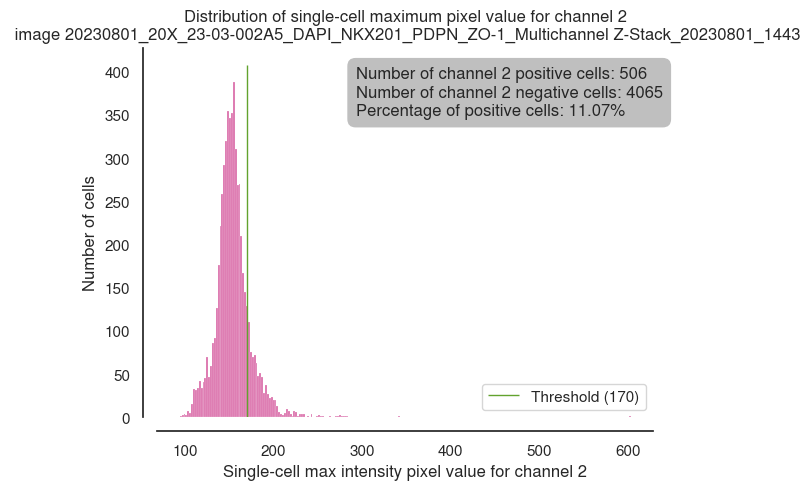

In [122]:
# sc_intensities = [np.max(t.properties['mean_intensity'][:,channel]) for t in tracks]
ax = sns.histplot(sc_intensities)
plt.vlines(x=threshold,
           ymax=ax.get_ylim()[-1],
           ymin=ax.get_ylim()[0],
           color=sns.color_palette('PiYG')[-1],  # my favorite colors :D
           linewidth=1)
sns.despine(offset = 10)
plt.xlabel(f'Single-cell max intensity pixel value for channel {channel}')
plt.ylabel('Number of cells')
plt.legend([f'Threshold ({threshold})'], loc='lower right')
ax.text(0.4, 0.95, 
        f'Number of channel {channel} positive cells: {n_positive}\nNumber of channel {channel} negative cells: {n_negative}\nPercentage of positive cells: {percentage:.2f}%',
        transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='grey', edgecolor='none', alpha=0.5))

image_name = os.path.basename(image_fn).replace('.tif','')
plt.title(f'Distribution of single-cell maximum pixel value for channel {channel}\n image {image_name}')
output_fn = os.path.join(sc_base_dir, f'{image_name}_ch{channel}_threshold_quantification.png')
# plt.xlim(0,5000)
plt.savefig(output_fn, bbox_inches = 'tight', dpi = 314)

# Save out as df/excel

In [ ]:
### define parameters to plot in table
cols = ['Cell ID', f'Max. int. {channels(0).name}', f'Max. int. {channels(1).name}', f'Max. int. {channels(2).name}', f'Max. int. {channels(3).name}', 'Average X', 'Average Y']
### extract some intial measurements
df = pd.DataFrame([(track.ID, np.nanmax(track['mean_intensity-0']),np.nanmax(track['mean_intensity-1']),np.nanmax(track['mean_intensity-2']),np.nanmax(track['mean_intensity-3']), np.mean(track.x), np.mean(track.y)) for track in tracks], columns= cols)